# Predictive Diagnosis of Heart Disease

## The challange was taken from: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob

In [2]:
pd.set_option('display.max_columns', 14)
pd.set_option('mode.chained_assignment', None)   # DISABLE SET COPY WARNING
columns = ['age', 'sex', 'chestPain', 'restBlPr', 'cholsterol', 'bloodSugar', 'restElcgr', 'maxHeartRateAch', 'exrIndAng', 'oldpeak', 'slope', 'ca', 'thal', 'diagnosis']

def name_columns(self): # give names to columns
    self.columns = columns
    return self

data = map(name_columns, map(pd.read_csv, glob.glob('*.data'))) # read all
dtframe = pd.concat(data) # concat
dtframe.reset_index(inplace=True, drop=True) # reindex
dtframe # display

,age,sex,chestPain,restBlPr,cholsterol,bloodSugar,restElcgr,maxHeartRateAch,exrIndAng,oldpeak,slope,ca,thal,diagnosis
0,29.0,1.0,2.0,120,243,0,0,160,0,0.0,?,?,?,0
1,29.0,1.0,2.0,140,?,0,0,170,0,0.0,?,?,?,0
2,30.0,0.0,1.0,170,237,0,1,170,0,0.0,?,?,6,0
3,31.0,0.0,2.0,100,219,0,1,150,0,0.0,?,?,?,0
4,32.0,0.0,2.0,105,198,0,0,165,0,0.0,?,?,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,54.0,0.0,4.0,127,333,1,1,154,0,0,?,?,?,1
912,62.0,1.0,1.0,?,139,0,1,?,?,?,?,?,?,0
913,55.0,1.0,4.0,122,223,1,1,100,0,0,?,?,6,2
914,58.0,1.0,4.0,?,385,1,2,?,?,?,?,?,?,0


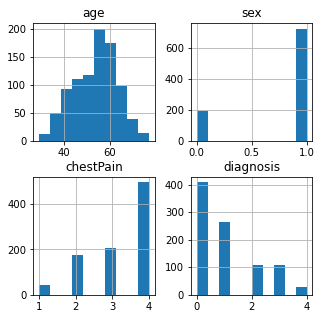

In [3]:
dtframe.hist(figsize=(5,5));

In [4]:
df_duplicated = dtframe.loc[dtframe.iloc[:,:-1].duplicated(keep=False)]

# se houver valores redundantes ou inconsistentes, imprima 
if len(df_duplicated)<=0:
    print('Não existem valores duplicados')
else:
    print(f'Amostras redundantes ou inconsistentes: ')
    display(df_duplicated)

Amostras redundantes ou inconsistentes: 


,age,sex,chestPain,restBlPr,cholsterol,bloodSugar,restElcgr,maxHeartRateAch,exrIndAng,oldpeak,slope,ca,thal,diagnosis
100,49.0,0.0,2.0,110,?,0,0,160,0,0.0,?,?,?,0
101,49.0,0.0,2.0,110,?,0,0,160,0,0.0,?,?,?,0
855,58.0,1.0,3.0,150,219,0,1,118,1,0,?,?,?,2
903,58.0,1.0,3.0,150,219,0,1,118,1,0,?,?,?,2


In [5]:
df_no_dupl = dtframe.drop_duplicates(keep = 'first') # drop duplicates
df_no_dupl.reset_index(inplace=True, drop=True)
df_duplicated = df_no_dupl.loc[df_no_dupl.iloc[:,:-1].duplicated(keep=False)]

# se houver valores redundantes ou inconsistentes, imprima 
if len(df_duplicated)>0:
    print(f'Amostras redundantes ou inconsistentes:\n ')
    display(df_duplicated)
else:
    print('Não existem valores duplicados')

Não existem valores duplicados


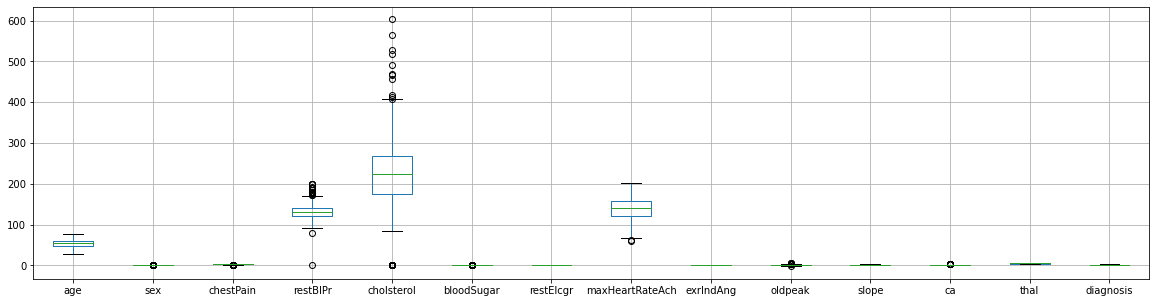

In [6]:
df_no_dupl.mask(df_no_dupl == '?', inplace=True)
df_no_dupl.mask(df_no_dupl == 'nan', inplace=True)
df_no_dupl.mask(df_no_dupl == 'NaN', inplace=True)
df_no_dupl.mask(df_no_dupl == 'NA', inplace=True)
df_no_dupl.mask(df_no_dupl == 'none', inplace=True)
df_no_dupl.mask(df_no_dupl == 'null', inplace=True)
df_no_dupl.mask(df_no_dupl == 'Null', inplace=True)

for atributo in (df_no_dupl.columns): # para cada atributo, transforma os valores em numeros
    df_no_dupl.loc[:, atributo] = pd.to_numeric(df_no_dupl.loc[:, atributo])
df_no_dupl.boxplot(figsize=(20,5));

In [7]:
# substituindo valores sem sentido por NaN
df_no_dupl.iloc[df_no_dupl['restBlPr'] == 0, 3:4] = None
df_no_dupl.iloc[df_no_dupl['cholsterol'] == 0, 4:5] = None

#Couting missing values
missing = pd.concat([df_no_dupl.shape[0] - df_no_dupl.count(), 100*(df_no_dupl.shape[0] - df_no_dupl.count())/df_no_dupl.shape[0]], axis=1)
missing.columns = ['Ausent Values', '%']
missing

,Ausent Values,%
age,0,0.000000
sex,0,0.000000
chestPain,0,0.000000
restBlPr,60,6.564551
cholsterol,200,21.881838
bloodSugar,89,9.737418
restElcgr,2,0.218818
maxHeartRateAch,55,6.017505
exrIndAng,55,6.017505
oldpeak,62,6.783370


In [8]:
dropedDf = df_no_dupl.drop(columns=['thal','ca']) #dropa os atributos com muitos valores faltantes

def trataFaltantes( df ):
    # Substitui os valores faltantes pela média dos outros valores do mesmo atributo
    # de amostras que sejam da mesma classe    
    for atributo in (df.columns): # para cada atributo
        # seleciona apenas as linhas da base de dados onde valor não é nulo
        notNull = df.loc[ ~pd.isnull(df[atributo])].copy()
        for classe in (df['diagnosis'].unique()): # para cada classe
            # calcula a media dos valores do atributo que são da mesma classe
            media = notNull.loc[ notNull['diagnosis'] == classe, atributo ].mean()
            # atribui a media para a respectiva classe
            for line in (pd.isnull(df.loc[df['diagnosis'] == classe, atributo]).index):
                if pd.isnull(df.loc[:,atributo].iloc[line]):
                    df.loc[:, atributo].iloc[line] = media
    return df

cleanDf = trataFaltantes(dropedDf.copy())

missing = pd.concat([cleanDf.shape[0] - cleanDf.count(), 100*(cleanDf.shape[0] - cleanDf.count())/cleanDf.shape[0]], axis=1)
missing.columns = ['Ausent Values', '%']
missing

,Ausent Values,%
age,0,0.0
sex,0,0.0
chestPain,0,0.0
restBlPr,0,0.0
cholsterol,0,0.0
bloodSugar,0,0.0
restElcgr,0,0.0
maxHeartRateAch,0,0.0
exrIndAng,0,0.0
oldpeak,0,0.0


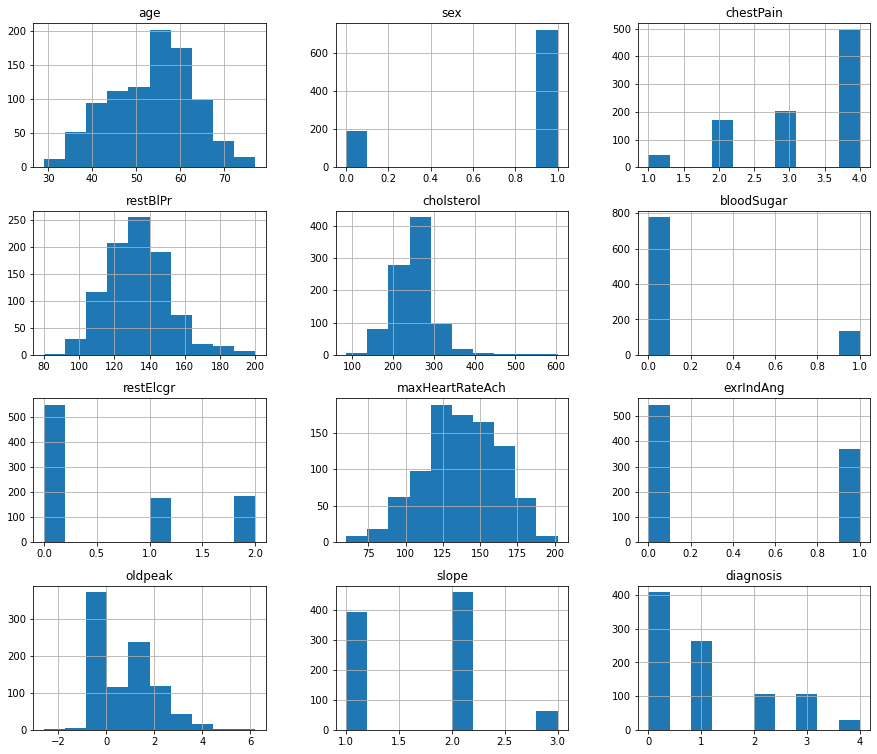

In [9]:
# arredondando valores que deveriam ser inteiros
cleanDf.iloc[:,5:7] = cleanDf.iloc[:,5:7].round(0)
cleanDf.loc[:,'exrIndAng'] = cleanDf.loc[:,'exrIndAng'].round(0)
cleanDf.loc[:,'slope'] = cleanDf.loc[:,'slope'].round(0)

#cleanDf.boxplot(figsize=(25,8))

cleanDf.hist(figsize=(15,13));

In [10]:
import sklearn as skl
from sklearn import model_selection
from sklearn import linear_model
from sklearn import neighbors

# copy DF and simplify the target (diagnosis) to True or False
uniClassCleanDF = cleanDf.copy()
uniClassCleanDF.loc[ uniClassCleanDF['diagnosis'] > 1, 'diagnosis'] = 1

# split data in input and ouput
y_data = uniClassCleanDF.loc[:,'diagnosis']
x_data = uniClassCleanDF.iloc[:,:-1]

# split data in train and test
x_train_data, x_test_data, y_train_data, y_test_data = skl.model_selection.train_test_split(x_data, y_data, test_size = 0.2)

# fit scalers
scalerN = skl.preprocessing.MinMaxScaler().fit(x_train_data)
scalerS = skl.preprocessing.StandardScaler().fit(x_train_data)
scalerR = skl.preprocessing.RobustScaler().fit(x_train_data)

# scale train data
xN_train_data = scalerN.transform(x_train_data)
xS_train_data = scalerS.transform(x_train_data)
xR_train_data = scalerR.transform(x_train_data)

#scale test data
xN_test_data = scalerN.transform(x_test_data)
xS_test_data = scalerS.transform(x_test_data)
xR_test_data = scalerR.transform(x_test_data)

# instance kfold
Kfold = skl.model_selection.KFold(n_splits=10, shuffle=True, random_state=5)

In [11]:
# K Nearest Neighbors
model_KNN = skl.neighbors.KNeighborsClassifier()

knn_resultsN = skl.model_selection.cross_val_score(model_KNN, xN_train_data, y_train_data, cv=Kfold)
knn_resultsS = skl.model_selection.cross_val_score(model_KNN, xS_train_data, y_train_data, cv=Kfold)
knn_resultsR = skl.model_selection.cross_val_score(model_KNN, xR_train_data, y_train_data, cv=Kfold)

print('Cross Validation Scores:')
print(f'Norm:   { knn_resultsN.mean()*100:.3f}%')
print(f'Stand:  { knn_resultsS.mean()*100:.3f}%')
print(f'Robust: { knn_resultsR.mean()*100:.3f}%')

model_KNN.fit(xN_train_data, y_train_data)
knnN_score = model_KNN.score(xN_test_data, y_test_data)

model_KNN.fit(xS_train_data, y_train_data)
knnS_score = model_KNN.score(xS_test_data, y_test_data)

model_KNN.fit(xR_train_data, y_train_data)
knnR_score = model_KNN.score(xR_test_data, y_test_data)

print('\nFinal Test Scores:')
print(f'Norm:   { knnN_score*100:.3f}%')
print(f'Stand:  { knnS_score*100:.3f}%')
print(f'Robust: { knnR_score*100:.3f}%')

Cross Validation Scores:
Norm:   83.173%
Stand:  84.541%
Robust: 84.807%

Final Test Scores:
Norm:   83.607%
Stand:  86.885%
Robust: 84.153%


In [12]:
# Logistic Regression
model_LR = skl.linear_model.LogisticRegression()

lr_resultsN = skl.model_selection.cross_val_score(model_LR, xN_train_data, y_train_data, cv=Kfold)
lr_resultsS = skl.model_selection.cross_val_score(model_LR, xS_train_data, y_train_data, cv=Kfold)
lr_resultsR = skl.model_selection.cross_val_score(model_LR, xR_train_data, y_train_data, cv=Kfold)

print('Cross Validation Scores:')
print(f'Norm:   { lr_resultsN.mean()*100:.3f}%')
print(f'Stand:  { lr_resultsS.mean()*100:.3f}%')
print(f'Robust: { lr_resultsR.mean()*100:.3f}%')

model_LR.fit(xN_train_data, y_train_data)
lrN_score = model_LR.score(xN_test_data, y_test_data)

model_LR.fit(xS_train_data, y_train_data)
lrS_score = model_LR.score(xS_test_data, y_test_data)

model_LR.fit(xR_train_data, y_train_data)
lrR_score = model_LR.score(xR_test_data, y_test_data)

print('\nFinal Test Scores:')
print(f'Norm:   { lrN_score*100:.3f}%')
print(f'Stand:  { lrS_score*100:.3f}%')
print(f'Robust: { lrR_score*100:.3f}%')

Cross Validation Scores:
Norm:   85.359%
Stand:  85.085%
Robust: 85.359%

Final Test Scores:
Norm:   81.967%
Stand:  83.060%
Robust: 83.060%


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()

rf_resultsN = skl.model_selection.cross_val_score(model_RF, xN_train_data, y_train_data, cv=5)
rf_resultsS = skl.model_selection.cross_val_score(model_RF, xS_train_data, y_train_data, cv=5)
rf_resultsR = skl.model_selection.cross_val_score(model_RF, xR_train_data, y_train_data, cv=5)

print('Cross Validation Scores:')
print(f'Norm:   { rf_resultsN.mean()*100:.3f}%')
print(f'Stand:  { rf_resultsS.mean()*100:.3f}%')
print(f'Robust: { rf_resultsR.mean()*100:.3f}%')

model_RF.fit(xN_train_data, y_train_data)
rfN_score = model_RF.score(xN_test_data, y_test_data)

model_RF.fit(xS_train_data, y_train_data)
rfS_score = model_RF.score(xS_test_data, y_test_data)

model_RF.fit(xR_train_data, y_train_data)
rfR_score = model_RF.score(xR_test_data, y_test_data)

print('\nFinal Test Scores:')
print(f'Norm:   { rfN_score*100:.3f}%')
print(f'Stand:  { rfS_score*100:.3f}%')
print(f'Robust: { rfR_score*100:.3f}%')

Cross Validation Scores:
Norm:   86.045%
Stand:  86.181%
Robust: 86.592%

Final Test Scores:
Norm:   87.978%
Stand:  87.432%
Robust: 87.978%


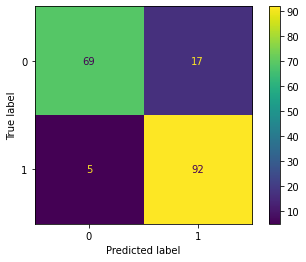

In [14]:
# RF with StandarkScaler choosed for deeper analis
from sklearn.metrics import classification_report, plot_confusion_matrix

# Predict
predictions = model_RF.predict(xR_test_data)

# Confusion Matrix
plot_confusion_matrix(model_RF, xR_test_data, y_test_data)
plt.show()

In [17]:
# precision, recall, support and f1-score
print(f'{classification_report(y_test_data, predictions)}')

              precision    recall  f1-score   support

           0       0.93      0.80      0.86        86
           1       0.84      0.95      0.89        97

    accuracy                           0.88       183
   macro avg       0.89      0.88      0.88       183
weighted avg       0.89      0.88      0.88       183



# TODO
## Maybe Focus at improve recall
## Try feature selection methods test results with less features (correlation and density)